# Cloud removal Analisys

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import random
from pathlib import Path

import pandas as pd

from utils.plots import (
    plot_monthly_water,
    plot_tif,
    plot_water_over_time,
    plot_water_x_cloud_percent,
    plot_water_x_cloud_percent_filter,
    plot_water_x_cloud_percent_over_time,
    plot_year_x_variable,
)
from utils.water import calculate_water_area


## Constants

In [2]:
root = Path("../data/02_boa_images/mare_reservatorio_deepwatermap_fmask")
metadata_path = (
    root
    / "metadata"
    / "metadata.csv"
)
PATH_SHAPEFILE = Path(
    "/media/weverton/D/Dev/python/Remote Sensing/tcc/GeoPipe/data/00_shapefiles/mare_reservatorio.geojson"
)
THRESHOLD = 1

In [3]:
root.resolve(), metadata_path.resolve()

(PosixPath('/media/weverton/D/Dev/python/Remote Sensing/tcc/GeoPipe/data/02_boa_images/mare_reservatorio_deepwatermap_fmask'),
 PosixPath('/media/weverton/D/Dev/python/Remote Sensing/tcc/GeoPipe/data/02_boa_images/mare_reservatorio_deepwatermap_fmask/metadata/metadata.csv'))

In [4]:
metadata = pd.read_csv(metadata_path.resolve())
metadata = metadata[['PRODUCT_ID', 'image_id', "location_name", 'file_name', 'CLOUDY_PIXEL_PERCENTAGE', 'CLOUD_COVERAGE_ASSESSMENT']]
metadata['water_mask_image_path'] = metadata.apply(lambda x: x['file_name'].replace('02_boa_images', '07_water_masks'), axis=1)
metadata['date'] = metadata.apply(lambda x: Path(x['file_name']).name.split('_')[-1].split('.')[0], axis=1)
metadata['year'] = metadata['date'].apply(lambda date: int(f"{date[:4]}"))
metadata['month'] = metadata['date'].apply(lambda date: int(f"{date[4:6]}"))
metadata['day'] = metadata['date'].apply(lambda date: int(f"{date[6:]}"))

metadata.head()

,PRODUCT_ID,image_id,location_name,file_name,CLOUDY_PIXEL_PERCENTAGE,CLOUD_COVERAGE_ASSESSMENT,water_mask_image_path,date,year,month,day
0,S2A_MSIL2A_20180227T124301_N0500_R009_T25MBN_2...,COPERNICUS/S2_SR_HARMONIZED/20180227T124301_20...,mare_reservatorio_deepwatermap_fmask,/media/weverton/D/Dev/python/Remote Sensing/tc...,28.230047,28.230047,/media/weverton/D/Dev/python/Remote Sensing/tc...,20180227,2018,2,27
1,S2A_MSIL2A_20181214T124301_N0211_R009_T25MBN_2...,COPERNICUS/S2_SR_HARMONIZED/20181214T124301_20...,mare_reservatorio_deepwatermap_fmask,/media/weverton/D/Dev/python/Remote Sensing/tc...,36.418882,36.418882,/media/weverton/D/Dev/python/Remote Sensing/tc...,20181214,2018,12,14
2,S2B_MSIL2A_20181219T124309_N0211_R009_T25MBN_2...,COPERNICUS/S2_SR_HARMONIZED/20181219T124309_20...,mare_reservatorio_deepwatermap_fmask,/media/weverton/D/Dev/python/Remote Sensing/tc...,10.458430,10.458430,/media/weverton/D/Dev/python/Remote Sensing/tc...,20181219,2018,12,19
3,S2A_MSIL2A_20181224T124311_N0211_R009_T25MBN_2...,COPERNICUS/S2_SR_HARMONIZED/20181224T124311_20...,mare_reservatorio_deepwatermap_fmask,/media/weverton/D/Dev/python/Remote Sensing/tc...,90.801119,90.801119,/media/weverton/D/Dev/python/Remote Sensing/tc...,20181224,2018,12,24
4,S2B_MSIL2A_20181229T124319_N0211_R009_T25MBN_2...,COPERNICUS/S2_SR_HARMONIZED/20181229T124319_20...,mare_reservatorio_deepwatermap_fmask,/media/weverton/D/Dev/python/Remote Sensing/tc...,23.021359,23.021359,/media/weverton/D/Dev/python/Remote Sensing/tc...,20181229,2018,12,29


In [5]:
metadata["file_name_clean"] = metadata["file_name"].apply(
    lambda x: x.replace("02_boa_images", "04_clean_images").replace(
        ".tif", "_clean.tif"
    )
)
metadata["water_mask_image_path_fmask"] = metadata[
    "water_mask_image_path"
].apply(
    lambda x: x.replace(".tif", "_clean.tif").replace("sume_reservatorio", "sume_reservatorio_deepwatermap_fmask", 1)
)
metadata["water_mask_image_path"] = metadata["water_mask_image_path"].apply(
    lambda x: x.replace(
        "sume_reservatorio", "sume_reservatorio_deepwatermap_no_preprocess", 1
    )
)


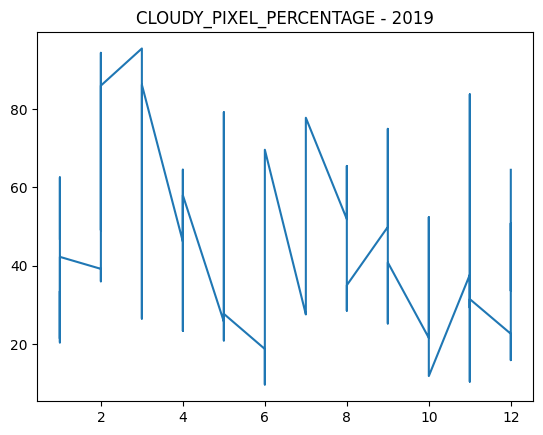

In [6]:
plot_year_x_variable(data=metadata, year=2019)

## Cloud distribution 

<Axes: >

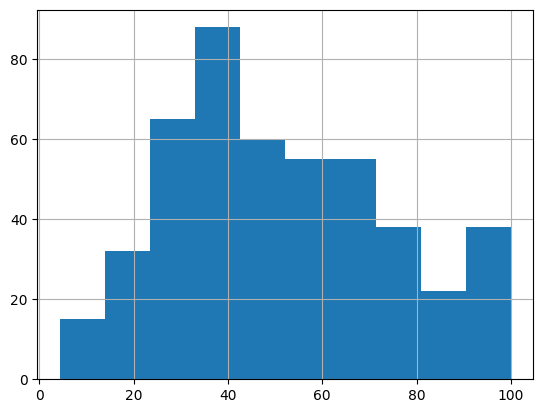

In [7]:
metadata['CLOUDY_PIXEL_PERCENTAGE'].hist()

## Water Area of DeepWaterMap Without Cloud  Removal

In [8]:
images = metadata['file_name']
images_water_mask = metadata['water_mask_image_path']
rand = random.randint(0, len(images))

m2, km2 = calculate_water_area(
    images_water_mask[rand], path_shapefile=PATH_SHAPEFILE, binarization_gt=THRESHOLD
)
print(images[rand])
print(images_water_mask[rand])
print(f"Água(m^2): {m2}")
print(f"Água(km^2): {km2}")
plot_tif(images[rand], bandas=[4, 3, 2], titulo="Sume - Imagem Original")
plot_tif(images_water_mask[rand], titulo="Sume - DeepWaterMap", binarization_gt=THRESHOLD)

RasterioIOError: /media/weverton/D/Dev/python/Remote Sensing/tcc/GeoPipe/data/07_water_masks/mare_reservatorio_deepwatermap_fmask/2022/sentinel_6B_BOA_S2_SR_mare_reservatorio_deepwatermap_fmask_20220417.tif: No such file or directory

### Water Area For Many Scenes

In [ ]:
m2_areas = []
km2_areas = []
for index, row in metadata.iterrows():
    m2, km2 = calculate_water_area(
        row['water_mask_image_path'],
          path_shapefile=PATH_SHAPEFILE,
          binarization_gt=THRESHOLD)
    m2_areas.append(m2)  # Convert m^2 to km^2
    km2_areas.append(km2)

metadata['m2_area_deepwatermap'] = pd.Series(m2_areas)
metadata['km2_area_deepwatermap'] = pd.Series(km2_areas)

In [ ]:
metadata[["m2_area_deepwatermap", "km2_area_deepwatermap"]]

,m2_area_deepwatermap,km2_area_deepwatermap
0,6.236375e+06,6.236375
1,9.125746e+06,9.125746
2,7.302902e+06,7.302902
3,4.140272e+06,4.140272
4,2.214748e+06,2.214748
...,...,...
475,9.764697e+06,9.764697
476,9.774847e+06,9.774847
477,9.716115e+06,9.716115
478,8.818785e+06,8.818785


#### Saving Areas to CSV

In [ ]:
try:
    areas = pd.read_csv('./data/areas.csv')
    areas["year"] = metadata["year"]
    areas["month"] = metadata["month"]
    areas["m2_area_deepwatermap"] = metadata["m2_area_deepwatermap"]
    areas["km2_area_deepwatermap"] = metadata["km2_area_deepwatermap"]
    areas["CLOUDY_PIXEL_PERCENTAGE"] = metadata["CLOUDY_PIXEL_PERCENTAGE"]
    areas.to_csv('./data/areas.csv', index=False)
except FileNotFoundError:
    metadata[["m2_area_deepwatermap", "km2_area_deepwatermap"]].to_csv('./data/areas.csv', index=False)

#### Plots

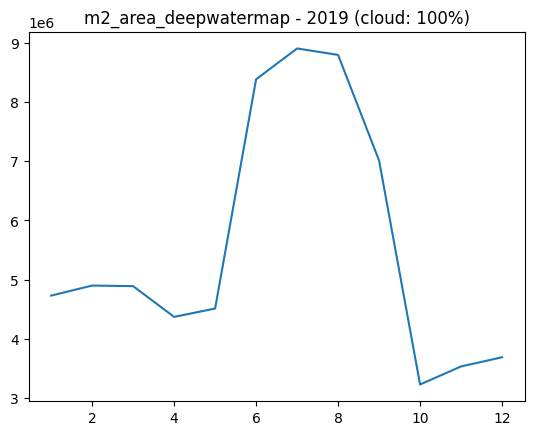

In [ ]:
plot_water_x_cloud_percent_filter(data=metadata, year=2019, y_varible="m2_area_deepwatermap", cloud_percent=100)

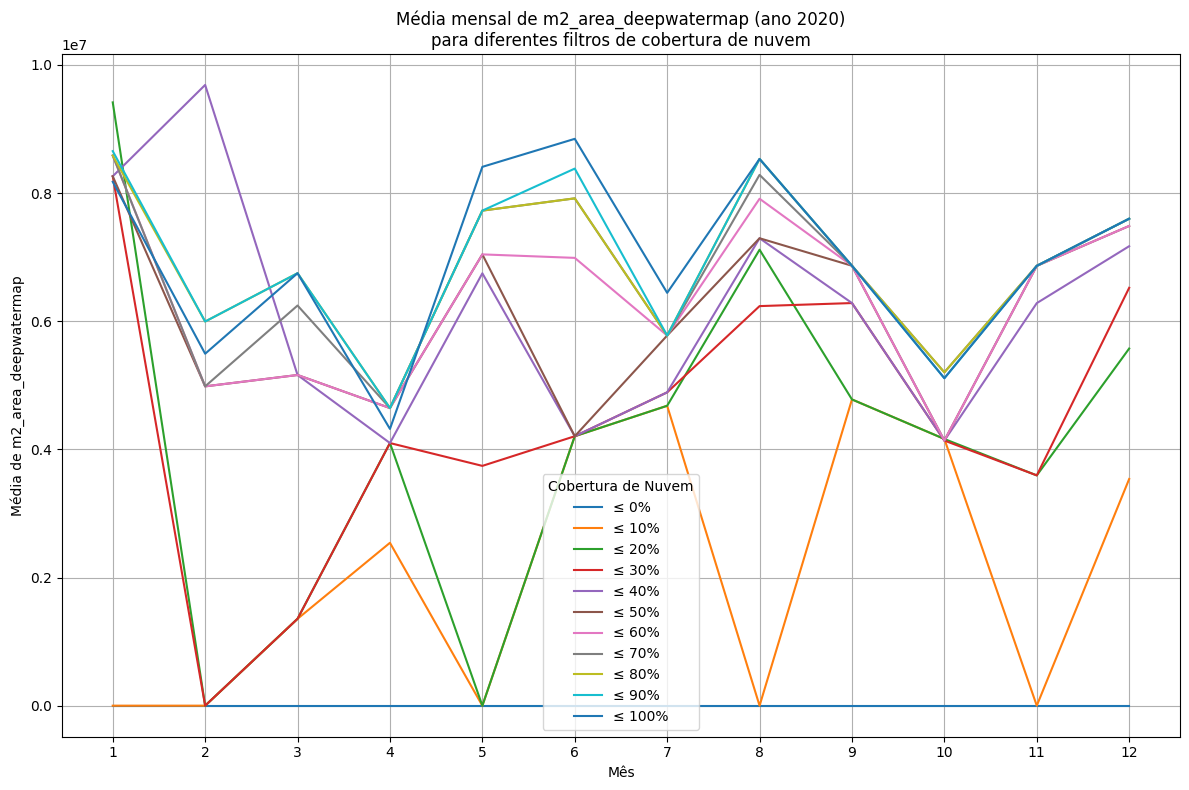

In [ ]:
plot_water_x_cloud_percent(metadata, year=2020, y_variable='m2_area_deepwatermap')


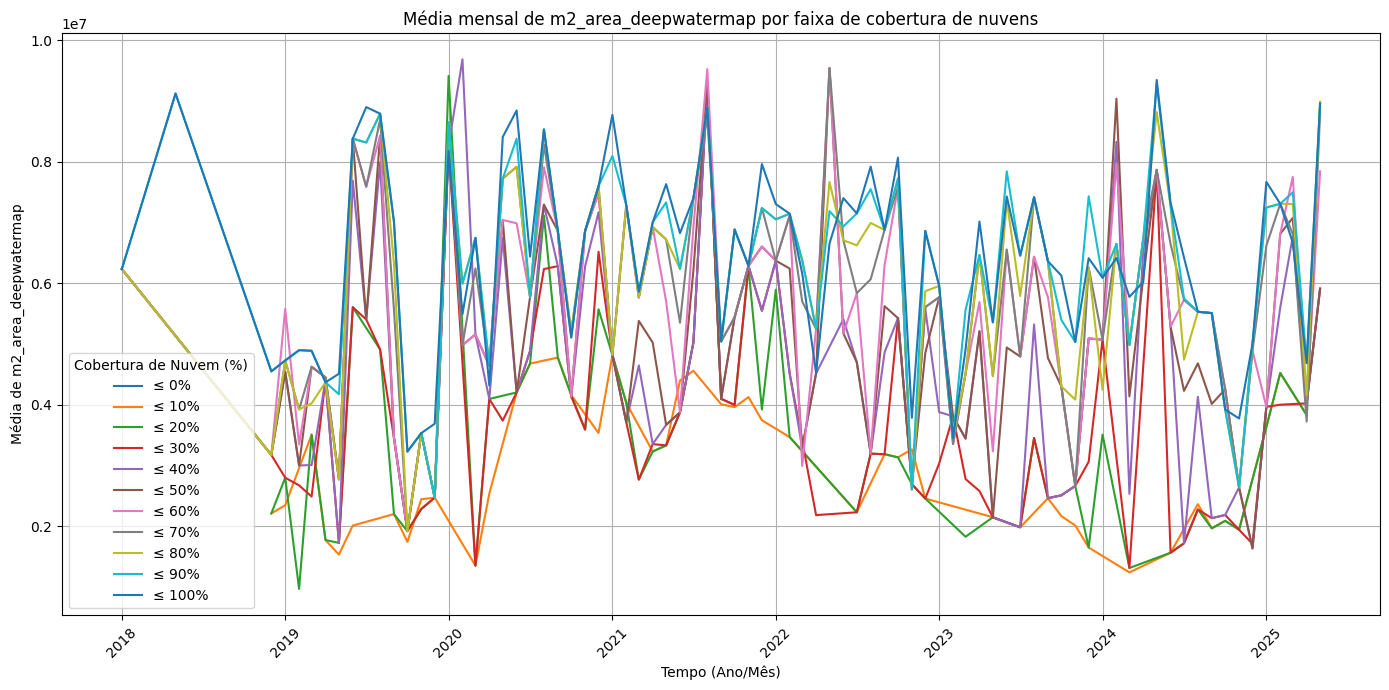

In [ ]:
plot_water_x_cloud_percent_over_time(metadata, y_variable='m2_area_deepwatermap')

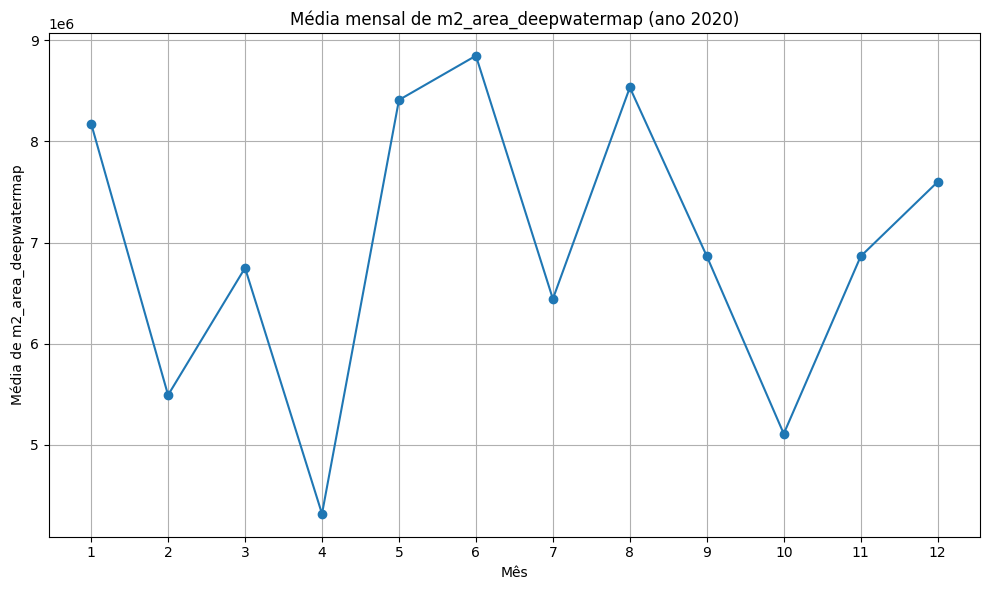

In [ ]:
plot_monthly_water(metadata, year=2020, y_variable='m2_area_deepwatermap')

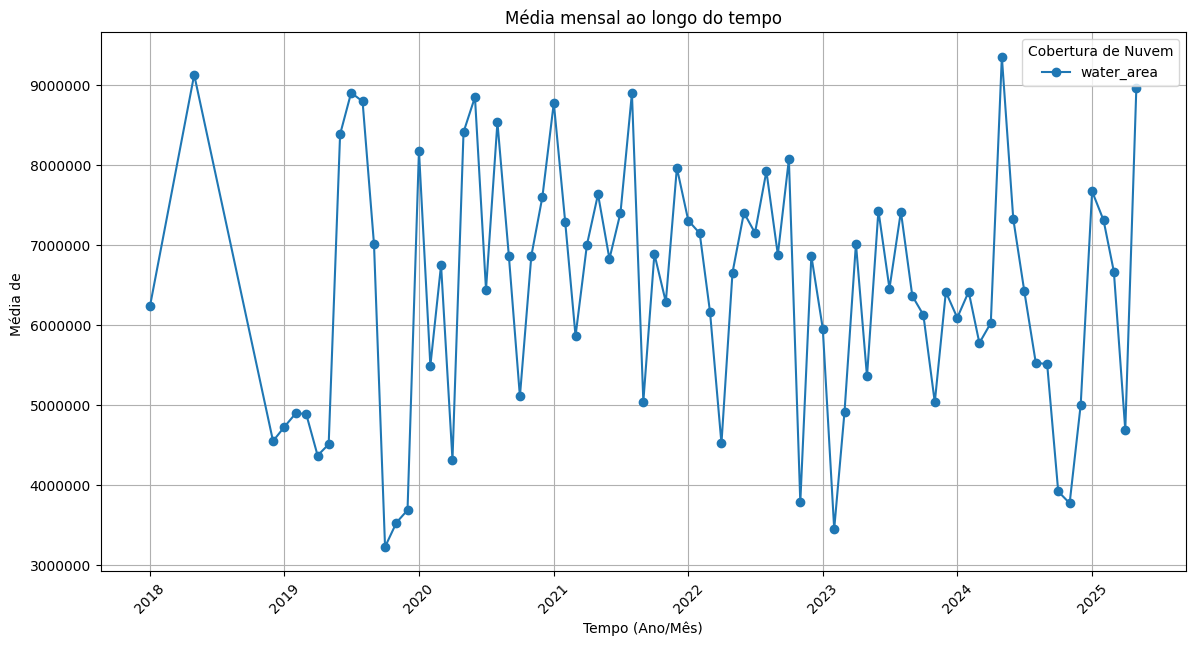

In [ ]:
plot_water_over_time(metadata, y_variables=['m2_area_deepwatermap'])

## Water Area of DeepWaterMap With Cloud Removal

In [9]:
images = metadata['file_name_clean']
images_water_mask = metadata['water_mask_image_path_fmask']
rand = random.randint(0, len(images))

m2, km2 = calculate_water_area(
    images_water_mask[rand], path_shapefile=PATH_SHAPEFILE, binarization_gt=THRESHOLD
)
print(images[rand])
print(images_water_mask[rand])
print(f"Água(m^2): {m2}")
print(f"Água(km^2): {km2}")
plot_tif(images_water_mask[rand], binarization_gt=THRESHOLD)

RasterioIOError: /media/weverton/D/Dev/python/Remote Sensing/tcc/GeoPipe/data/07_water_masks/mare_reservatorio_deepwatermap_fmask/2023/sentinel_6B_BOA_S2_SR_mare_reservatorio_deepwatermap_fmask_20230606_clean.tif: No such file or directory

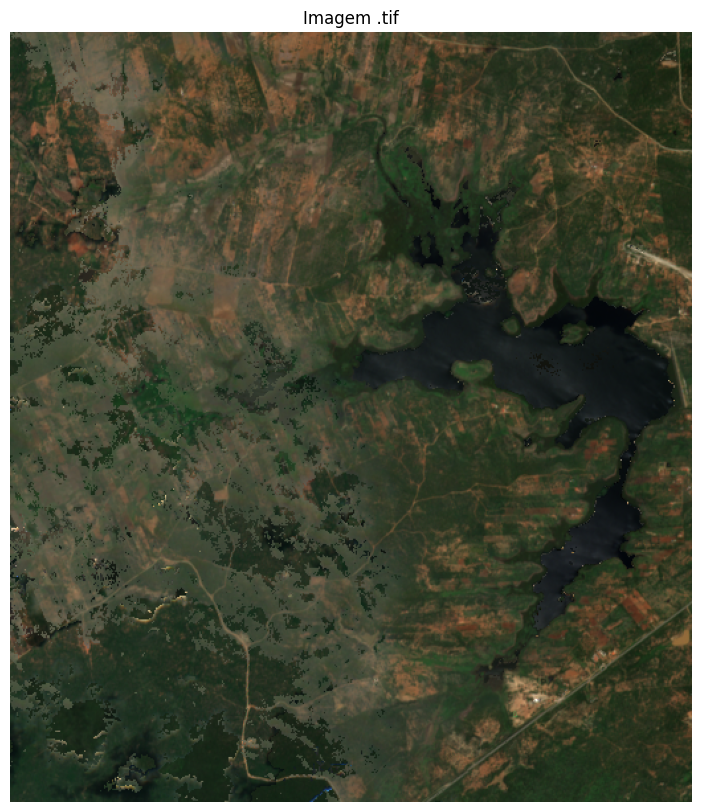

In [ ]:
plot_tif(images[rand], bandas=[4, 3, 2])

### Water Area For Many Scenes

In [ ]:
m2_areas = []
km2_areas = []
for index, row in metadata.iterrows():
    try:
        m2, km2 = calculate_water_area(row['water_mask_image_path_fmask'], path_shapefile=PATH_SHAPEFILE, binarization_gt=THRESHOLD)
        m2_areas.append(m2)
        km2_areas.append(km2)
    except Exception as e:
        print(e)
        print(f"Error to calculate water area of {row['water_mask_image_path_fmask']}")

metadata['m2_area_fmask_deepwatermap'] = pd.Series(m2_areas)
metadata['km2_area_fmask_deepwatermap'] = pd.Series(km2_areas)

/media/weverton/D/Dev/python/Remote Sensing/tcc/GeoPipe/data/07_water_masks/sume_reservatorio_deepwatermap_fmask/2018/sentinel_6B_BOA_S2_SR_sume_reservatorio_20180106_clean.tif: No such file or directory
Error to calculate water area of /media/weverton/D/Dev/python/Remote Sensing/tcc/GeoPipe/data/07_water_masks/sume_reservatorio_deepwatermap_fmask/2018/sentinel_6B_BOA_S2_SR_sume_reservatorio_20180106_clean.tif
/media/weverton/D/Dev/python/Remote Sensing/tcc/GeoPipe/data/07_water_masks/sume_reservatorio_deepwatermap_fmask/2018/sentinel_6B_BOA_S2_SR_sume_reservatorio_20180531_clean.tif: No such file or directory
Error to calculate water area of /media/weverton/D/Dev/python/Remote Sensing/tcc/GeoPipe/data/07_water_masks/sume_reservatorio_deepwatermap_fmask/2018/sentinel_6B_BOA_S2_SR_sume_reservatorio_20180531_clean.tif
/media/weverton/D/Dev/python/Remote Sensing/tcc/GeoPipe/data/07_water_masks/sume_reservatorio_deepwatermap_fmask/2018/sentinel_6B_BOA_S2_SR_sume_reservatorio_20181217_clean

In [ ]:
metadata[["m2_area_fmask_deepwatermap", "km2_area_fmask_deepwatermap"]]

,m2_area_fmask_deepwatermap,km2_area_fmask_deepwatermap
0,2.868283e+06,2.868283
1,2.729732e+06,2.729732
2,2.188929e+06,2.188929
3,9.866097e+05,0.986610
4,2.035893e+06,2.035893
...,...,...
475,3.233581e+06,3.233581
476,3.041225e+06,3.041225
477,NaN,NaN
478,NaN,NaN


#### Saving Areas to CSV

In [ ]:
try:
    areas = pd.read_csv('./data/areas.csv')
    areas["year"] = metadata["year"]
    areas["month"] = metadata["month"]
    areas["m2_area_fmask_deepwatermap"] = metadata["m2_area_fmask_deepwatermap"]
    areas["km2_area_fmask_deepwatermap"] =metadata["km2_area_fmask_deepwatermap"]
    areas.to_csv('./data/areas.csv', index=False)
except FileNotFoundError:
    metadata[["m2_area_fmask_deepwatermap", "km2_area_fmask_deepwatermap"]].to_csv('./data/areas.csv', index=False)

#### Plots

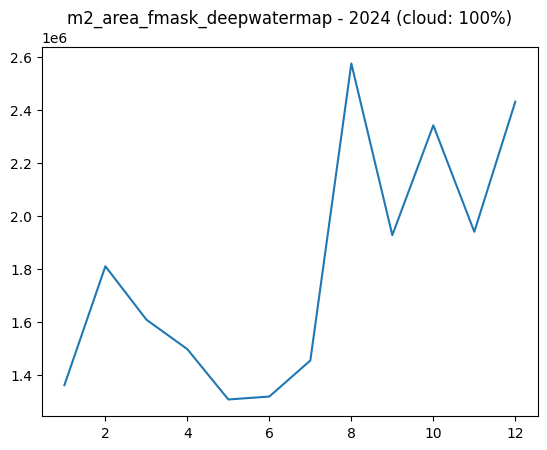

In [ ]:
plot_water_x_cloud_percent_filter(data=metadata, year=2024, y_varible='m2_area_fmask_deepwatermap', cloud_percent=100)

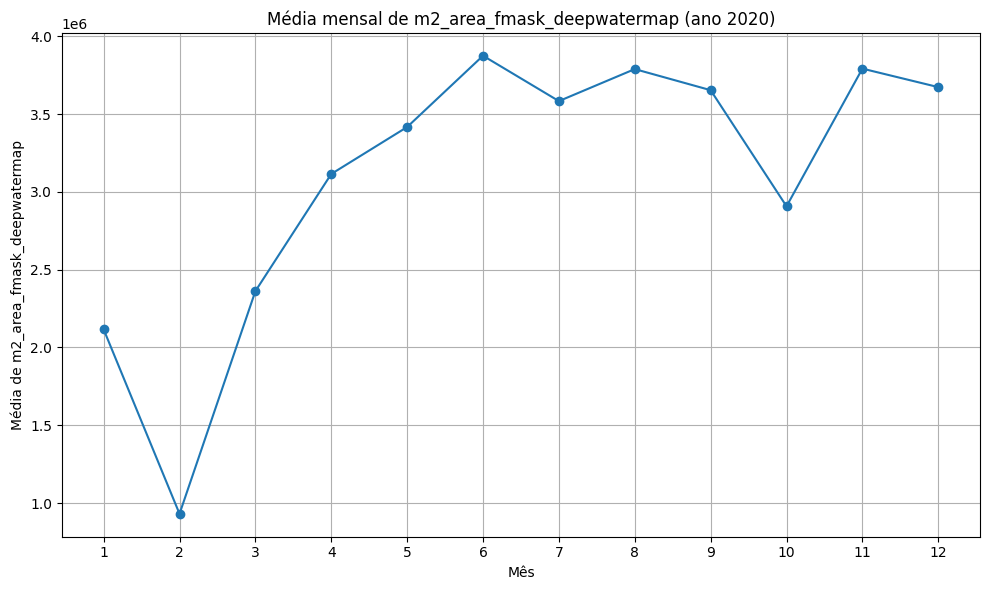

In [ ]:
plot_monthly_water(metadata, year=2020, y_variable='m2_area_fmask_deepwatermap')

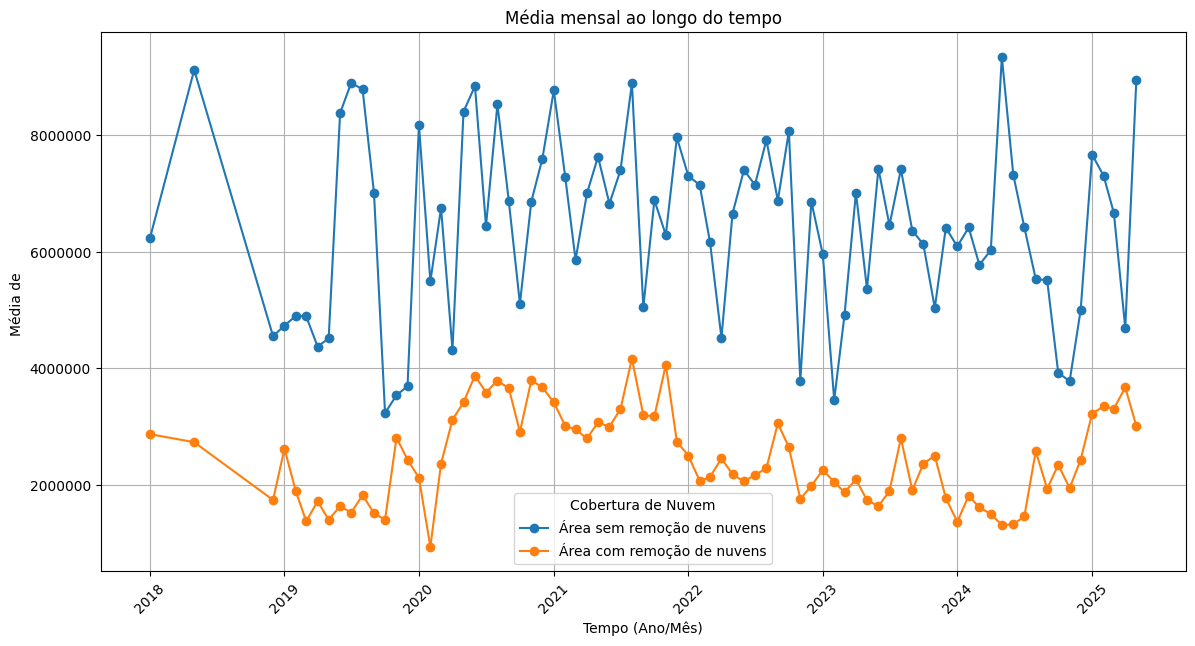

In [ ]:
plot_water_over_time(metadata, y_variables=['m2_area_deepwatermap', 'm2_area_fmask_deepwatermap'], labels=['Área sem remoção de nuvens', 'Área com remoção de nuvens'])

## Volume